In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import torch

# no warnings
import warnings
warnings.filterwarnings('ignore')

# import knn and mlp implementations
import sys  
sys.path.insert(0, '../src/models')
from knn import knn
from mlp import run_mlp

## Exploring the Data

The data is collected and prepared as described [here](https://github.com/amandashu/Cupcake-Muffin-Classification/blob/main/reports/clean.md). The data seen below contains the following columns:

- **link**: link to the recipe
- **blog**: blog name where the recipe comes from
- **type**: cupcake or muffin
- **Flour (%)**: percent of the six ingredients that flour takes up
- the rest of the columns **Baking Powder (%)**, **Butter (%)**, **Sugar (%)**, **Eggs (%)**, and **Vanilla (%)** are similar to **Flour (%)**

In [2]:
recipes = pd.read_csv('../data/recipes_clean.csv')
recipes.head()

,link,blog,type,Flour (%),Baking Powder (%),Butter (%),Sugar (%),Eggs (%),Vanilla (%)
0,https://www.thebakerchick.com/strawberry-lemon...,The Baker Chick,cupcake,42.352941,0.882353,14.117647,28.235294,14.117647,0.294118
1,https://www.thebakerchick.com/apple-cider-cupc...,The Baker Chick,cupcake,46.451613,1.290323,15.483871,20.645161,15.483871,0.645161
2,https://www.thebakerchick.com/vegan-chocolate-...,The Baker Chick,cupcake,49.202733,2.733485,14.578588,32.801822,0.000000,0.683371
3,https://www.thebakerchick.com/perfect-vanilla-...,The Baker Chick,cupcake,47.151277,0.982318,9.430255,33.005894,9.430255,0.000000
4,https://www.thebakerchick.com/caramel-mocha-ic...,The Baker Chick,cupcake,38.400000,3.466667,6.400000,38.400000,12.800000,0.533333


There are about 140 cupcake recipes with approximately equal number of recipes coming from each of the three blogs. There are about 80 muffin recipes with the majority coming from Sally's Baking Addiction.

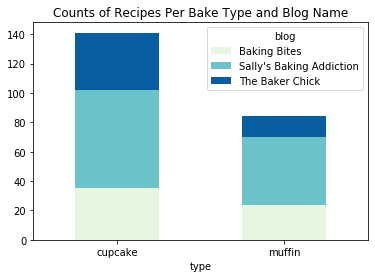

In [3]:
# counts of recipes per bake type and blog name
counts = recipes.groupby(['blog','type']).size().reset_index(name='Count')
pivot_df = counts.pivot_table(index='type',columns='blog',values='Count')
pivot_df.plot(kind='bar',stacked=True,colormap=ListedColormap(sns.color_palette("GnBu", 10)))
plt.title('Counts of Recipes Per Bake Type and Blog Name')
plt.xticks(rotation=0)
plt.show()

The following displays the density plots of each ingredient by bake type. The distribution of flour and baking powder for muffins lie higher than that of cupcakes. On the other higher, cupcakes' distribution of butter, sugar, eggs, and vanilla lie slightly higher than muffins. Visually, the largest differences seem to be in flour and sugar, where muffins have more flour and less sugar than cupcakes.

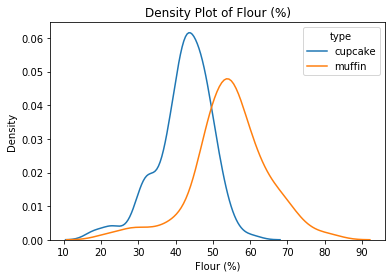

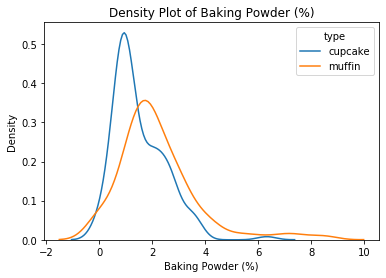

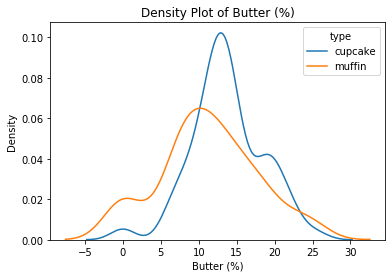

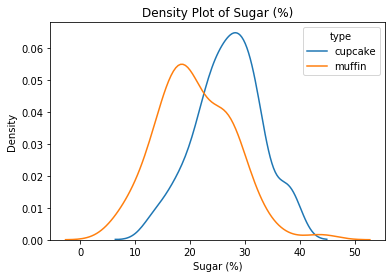

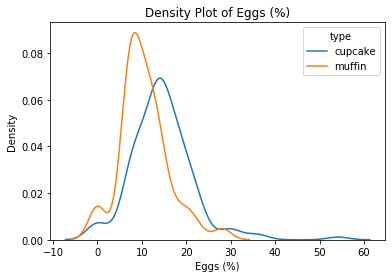

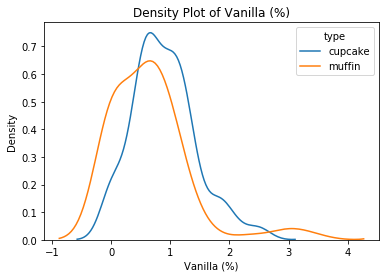

In [4]:
types = recipes['type'].unique()
ingredients = recipes.columns[3:]
for i in ingredients:
    for t in types:
        subset = recipes.loc[recipes['type']==t,i]
        sns.distplot(subset, hist = False, label=t)
    plt.legend(prop={'size': 10}, title = 'type')
    plt.title('Density Plot of ' + i)
    plt.ylabel('Density')
    plt.show()

### Simulation: Are the distribution of muffin ingredients different than that of cupcake ingredients?
Based on the earlier density plots and bar chart below, it seems that muffins and cupcakes do differ in their distribution of ingredients. To investigate further whether that might be true, I conduct a simulation as described below.

**Null hypothesis**: The distribution of muffin ingredients are the same as the distribution of cupcake ingredients. In other words, any differences seen in the data are due to random chance.

**Alternate hypothesis**: The distribution of muffin ingredients are *not* the same as the distribution of cupcake ingredients. 

**Test statistic**: Total variation distance, defined by the sum of the absolute differences between mean ingredient amounts, divided by 2. This measures how far two probability distributions are from one another. The observed total variation distance in the data is 12.9.

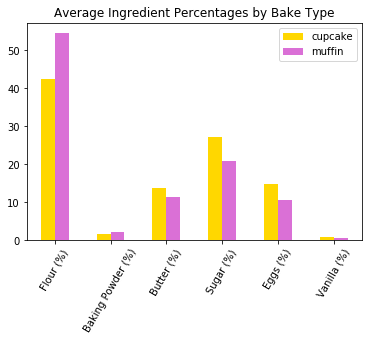

In [5]:
def mean_ingredients(df, col, t):
    """
    Takes in a dataframe like recipes, filters where col == t, and applys mean function to every column
    """
    return df.loc[df[col]==t,ingredients].apply(np.mean).rename(t)

# observed means ingredient percentages for cupcakes and muffins
cupcake_mean = mean_ingredients(recipes, 'type', 'cupcake')
muffin_mean = mean_ingredients(recipes, 'type', 'muffin')
pd.concat([cupcake_mean,muffin_mean],axis=1).plot(kind='bar', color=['gold','orchid'])
plt.title('Average Ingredient Percentages by Bake Type')
plt.xticks(rotation=60)
plt.show()

In [6]:
# observed tvd
def tvd(d1, d2):
    """
    Returns total variation distance between two distributions
    """
    return sum(np.abs(d1 - d2)) / 2

observed_tvd = tvd(cupcake_mean, muffin_mean)
print("Observed TVD: " + str(observed_tvd))

Observed TVD: 12.90807530108296


In the simulation, I shuffle the type column of the dataset 500 times, each time calculating the total variation distance between cupcake and muffin ingredient distributions with the newly shuffled data. If the null hypothesis is true, the observed total variable distance should fall within the distribution of simulated total variation distances, since if cupcakes and muffins are similiar in ingredients, the type label could be interchangable.

In the plot below, the observed total variation distance is in red, and it lies far outside of the distribution of simulated total variation distances computed under the null hypothesis. This indicates that the observed total variable distance seen is likely not due to chance, suggesting that there is a difference between the distributions of the two groups. 

In [7]:
def simulate_tvd():
    """
    Shuffles the type column in recipes data frame and returns total variable distance with shuffled data
    """
    shuffled_df = recipes.assign(shuffled_typed = recipes['type'].sample(frac=1).values)
    cupcake_mean = mean_ingredients(shuffled_df, 'shuffled_typed', 'cupcake')
    muffin_mean = mean_ingredients(shuffled_df, 'shuffled_typed', 'muffin')
    return tvd(cupcake_mean, muffin_mean)

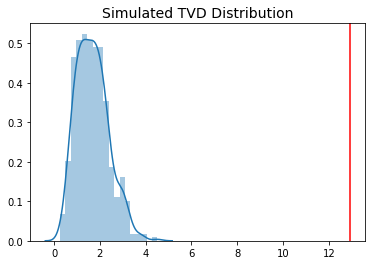

In [8]:
# run 500 simulations
tvds = []
for i in np.arange(500):
    tvds.append(simulate_tvd())

# plot simulated tvds with observed tvd
sns.distplot(tvds)
plt.axvline(observed_tvd, color = 'red')
plt.title("Simulated TVD Distribution", fontsize=14)
plt.show()

## Models: Can you predict whether a recipe is a cupcake or muffin based on its ingredients?

I run three different classification models (K nearest neighbor, multilayer perceptron, and support vector machines) in order to see if it is possible to accurately predict whether a recipe is a cupcake or muffin based on its ingredients. An accuracy score for these models above 50% (a random guess) would indicate that good predictions are possible and cupcake and muffin ingredients likely differ.

First, I split the data into a training and testing dataset. I define a label of 1 to be muffin and 0 to be cupcake.

In [9]:
X = recipes[ingredients]
y = recipes['type'].apply(lambda x:1 if x=='muffin' else 0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=234)

### Decision Trees

Before running any models, I use a decision tree classifier for feature selection. The decision tree classifier assigns a score to each feature, which meausures its importance towards predicting the label. I find that flour and baking powder are the top two most important features. Feature selection is useful as with a simpler model that does not capture the randomness of unimportant features, the model might perform better to unseen datasets. I will run my models with all features and with these two features to see if having less features improves the accuracy of the models.

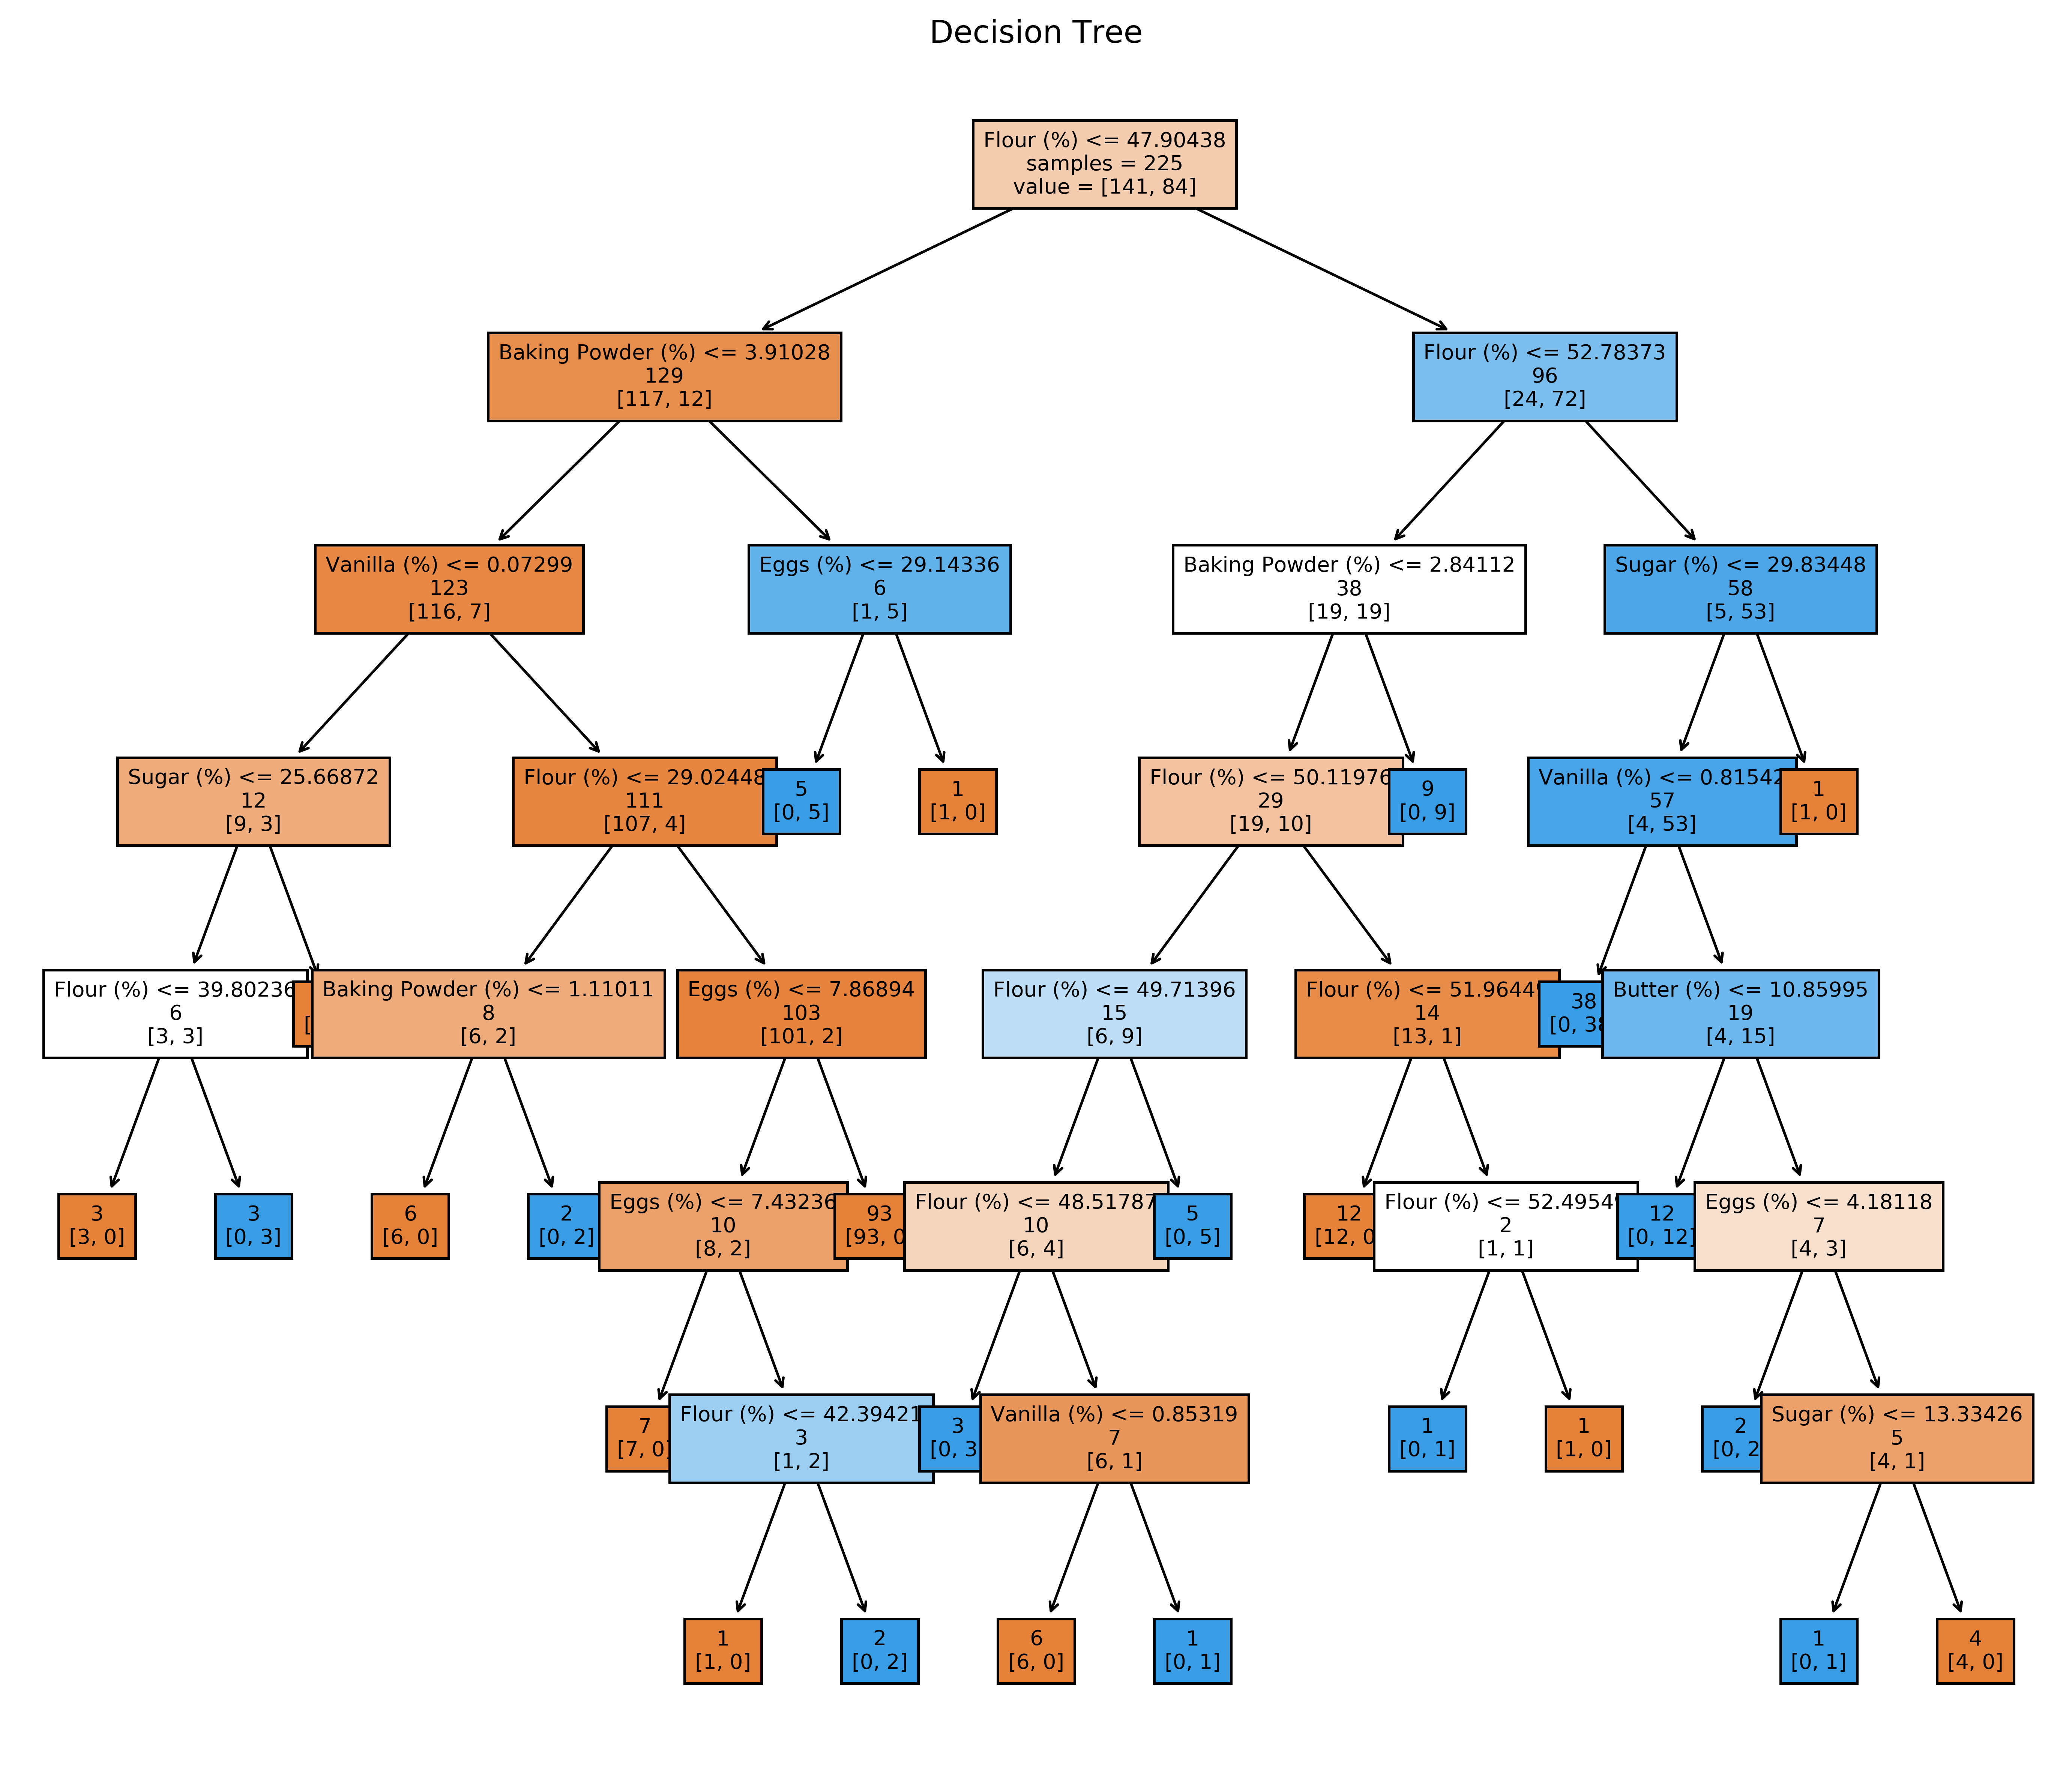

In [11]:
# fit decision tree
model = DecisionTreeClassifier()
model.fit(X, y)

# plot decision tree
fig = plt.figure(figsize = (14,12), dpi=500)
tree.plot_tree(model,feature_names = ingredients,filled=True,fontsize=8,label='root',impurity=False, precision=5)
plt.title("Decision Tree")
plt.show()

Feature: Flour (%), Score: 0.6828125438315554
Feature: Baking Powder (%), Score: 0.1500197082581312
Feature: Butter (%), Score: 0.02742418355920196
Feature: Sugar (%), Score: 0.04558638433942521
Feature: Eggs (%), Score: 0.057790984602888874
Feature: Vanilla (%), Score: 0.03636619540879734


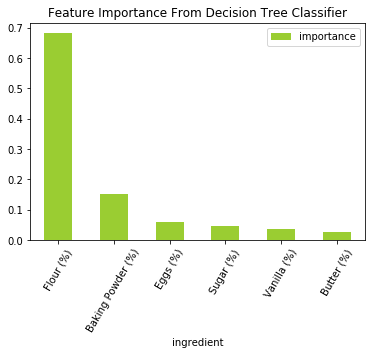

In [12]:
# summarize feature importance
importance = list(zip(ingredients,model.feature_importances_))
for i in importance:
    print('Feature: {0}, Score: {1}'.format(i[0],i[1]))
    
# plot feature importance
importance_df = pd.Series(importance).apply(pd.Series).rename(
    {0:'ingredient',1:'importance'},axis=1
    ).set_index('ingredient').sort_values(by='importance',ascending=False)
importance_df.plot(kind='bar', color='yellowgreen')
plt.xticks(rotation=60)
plt.title("Feature Importance From Decision Tree Classifier")
plt.show()

### KNN
The K Nearest Neighbor Classifier (KNN) assigns a testing datapoint the majority label to the nearest k training points to itself. See [here](https://github.com/amandashu/Cupcake-Muffin-Classification/blob/main/src/models/knn.py) for the implementation of KNN algorithm, which uses the Euclidean measure of calculating distances and a k value of 5.

The accuracy score of KNN classifier including all features is 0.721, and it increases to 0.779 with only flour and baking powder features. This suggest the fist model was overfitting.

In [13]:
# KNN
preds = knn(X_train, y_train, X_test)
print("KNN accuracy score with all features: " + str(accuracy_score(preds, y_test)))

preds = knn(X_train[['Flour (%)', 'Baking Powder (%)']],y_train, X_test[['Flour (%)', 'Baking Powder (%)']])
print("KNN accuracy score with only Flour and Baking Powder: " + str(accuracy_score(preds, y_test)))

KNN accuracy score with all features: 0.7205882352941176
KNN accuracy score with only Flour and Baking Powder: 0.7794117647058824


### MLP

The next model is a multilayer perceptron (MLP) with a single hidden layer and a logistic activation function. See [here](https://github.com/amandashu/Cupcake-Muffin-Classification/blob/main/src/models/mlp.py) for the implementation of MLP. I use a hidden layer size of 8 and learning rate of 0.0005. To train, I run 500 epochs, each looping through the training data in batches of 30 datapoints. 

The plot below shows the training loss during training. The accuracy score of MLP with all features is the same as the KNN classifier with two features. With only two features, the accuracy score decreases so I do not include the plot here.

Test accuracy: 0.7794117647058824


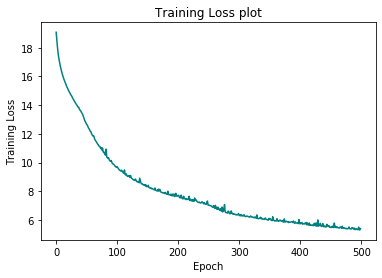

In [14]:
# MLP inputs
input_size = 6
output_size = 2
hidden_size = 8
learning_rate = 0.0005
epochs = 500

# set seed
torch.manual_seed(0)
np.random.seed(0)

run_mlp(X_train, y_train, X_test, y_test, input_size, hidden_size, output_size, learning_rate, epochs)

### SVM
Support vector machines finds a best separating decision boundary that maximizes the distance between itself and the support vectors, or the closest points. The C parameter determines how robust the classifier will be to outliers, or points that fall within the margin or are classified incorrectly. A higher C value allows less points to be misclassified (hard-margin) and a lower C value allows more points to be misclassified (soft-margin). I use grid search to find that a C of 10 is optimal. 

The accuracy of SVM with all features is 0.765, but with only flour and baking powder, it is 0.721.

In [15]:
# find best C
parameters = {'C':[10000, 1000, 100, 10,1,0.1,0.01,0.001,0.0001]}
clf = SVC()
grid = GridSearchCV(clf, parameters)
grid.fit(X_train,y_train)
print("Best C value: " + str(grid.best_params_['C']))

# SVM all features
clf = SVC(**grid.best_params_)
clf.fit(X_train, y_train)
print("SVM accuracy score with all features: " + str(accuracy_score(clf.predict(X_test), y_test)))

# SVM two features
clf = SVC(**grid.best_params_)
clf.fit(X_train[['Flour (%)', 'Baking Powder (%)']], y_train)
print("SVM accuracy score with only Flour and Baking Powder: " + str(accuracy_score(
    clf.predict(X_test[['Flour (%)', 'Baking Powder (%)']]), y_test)))

Best C value: 10
SVM accuracy score with all features: 0.7647058823529411
SVM accuracy score with only Flour and Baking Powder: 0.7205882352941176


With the above classifiers, I am able to classify recipes to be muffins or cupcakes with an accuracy of between 72% - 78%, which is higher than a random guess (50%). This suggests that the proportion of ingredients that go into muffins and cupcakes differ and these are different bakes.